# laboratorium 12: Analiza obrazow przy pomocy sieci konwolucyjnych

In [1]:
import tensorflow as tf
from tensorflow import keras

## 1 Ladowanie danych

In [2]:
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"], 
    as_supervised=True,
    with_info=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-10 14:25:00.675120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-10 14:25:00.675210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [3]:
#info o datasetcie
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

2022-06-10 14:25:01.000716: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-10 14:25:01.072527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


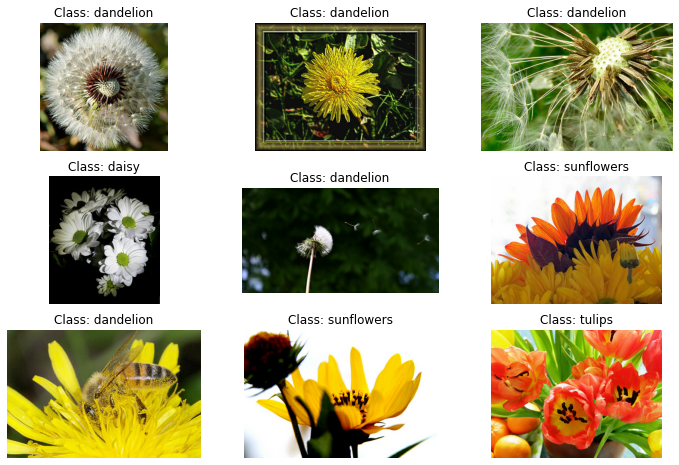

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    
plt.show(block=False)

## 2 Budujemy prosta siec CNN

### 2.1 Przygotowanie danych

In [6]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [7]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

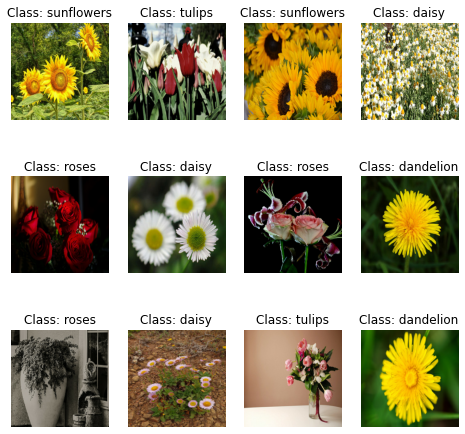

In [8]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

### 2.2 Budowa sieci

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size = 3, activation = 'relu', padding="SAME")

model = keras.models.Sequential([
    keras.layers.Rescaling(scale=1./255),
    DefaultConv2D(filters=32, kernel_size = 7, input_shape = [224,224,3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=5, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(train_set, epochs=10, validation_data=valid_set)

## 3 Uczenie transferowe

### 3.1 Przygotowanie danych

In [9]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

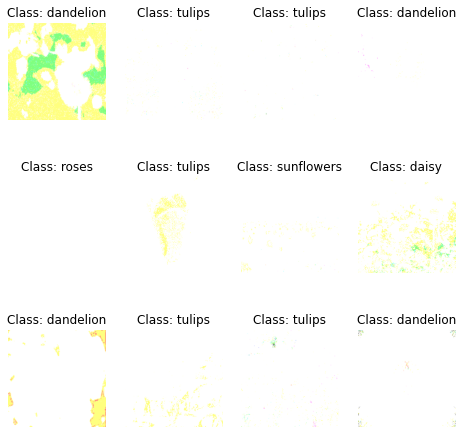

In [10]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")
plt.show()

### 3.2 Budowa sieci